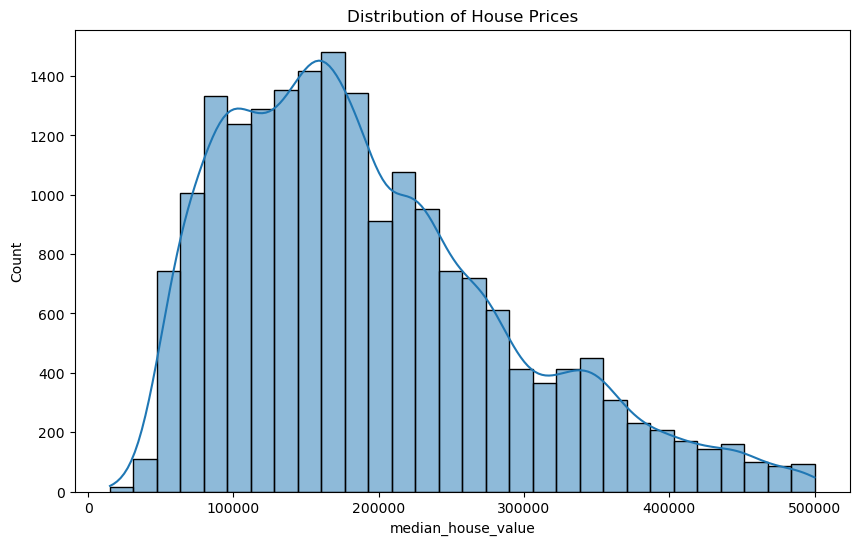

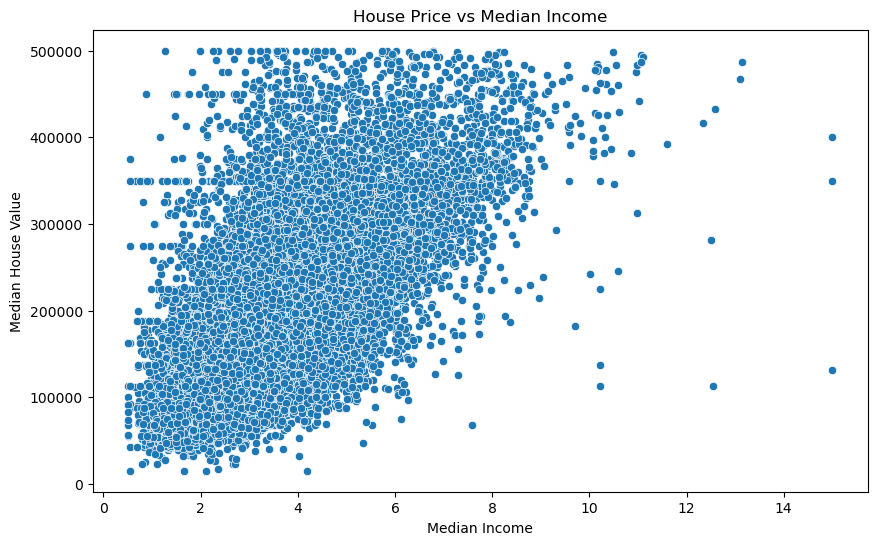

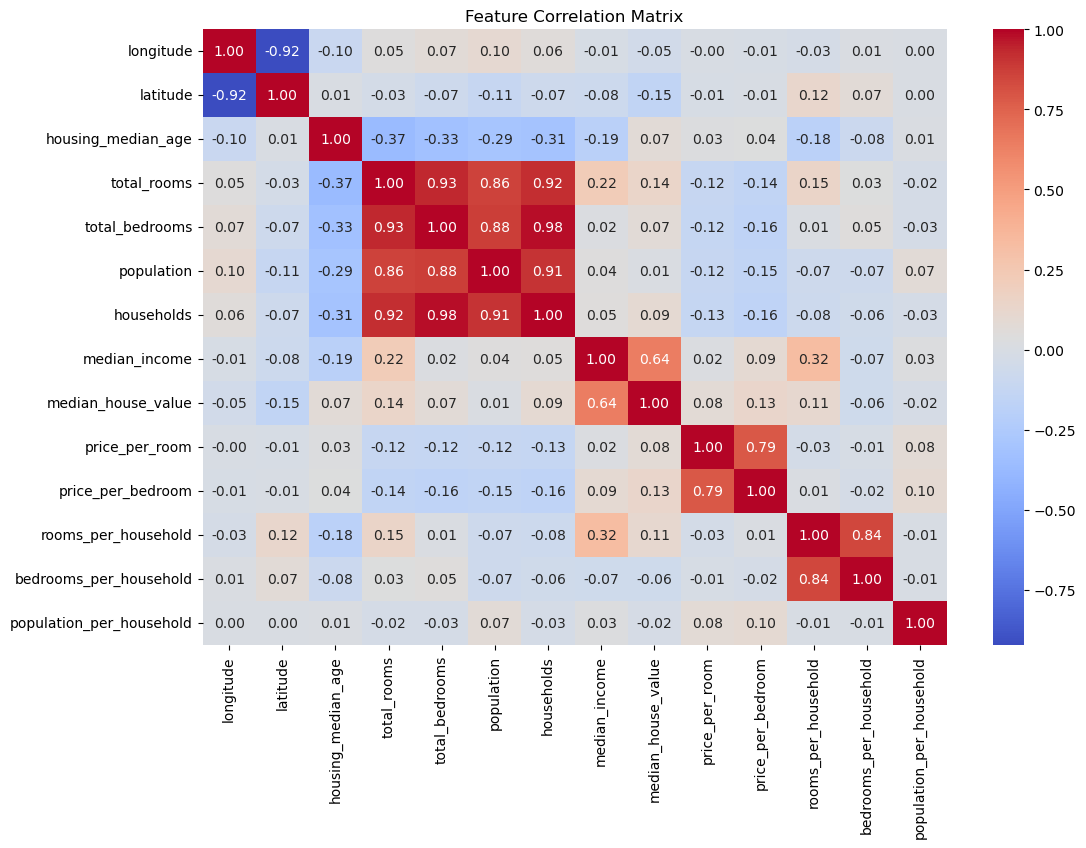

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import streamlit as st

# Load Dataset
df = pd.read_csv("housing.csv")

# Data Preprocessing
def preprocess_data(df):
    df = df.dropna()
    df = df[df['median_house_value'] < df['median_house_value'].quantile(0.99)]
    
    # Feature Engineering
    df['price_per_room'] = df['median_house_value'] / df['total_rooms']
    df['price_per_bedroom'] = df['median_house_value'] / df['total_bedrooms']
    df['rooms_per_household'] = df['total_rooms'] / df['households']
    df['bedrooms_per_household'] = df['total_bedrooms'] / df['households']
    df['population_per_household'] = df['population'] / df['households']
    
    return df

df = preprocess_data(df)

# Data Visualization
plt.figure(figsize=(10,6))
sns.histplot(df['median_house_value'], bins=30, kde=True)
plt.title("Distribution of House Prices")
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(x=df['median_income'], y=df['median_house_value'])
plt.title("House Price vs Median Income")
plt.xlabel("Median Income")
plt.ylabel("Median House Value")
plt.show()

plt.figure(figsize=(12,8))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()

# Splitting data
X = df.drop("median_house_value", axis=1)
y = df["median_house_value"]

# Handling categorical and numerical data
# Pipeline is used to automate data preprocessing in a structured way.
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = ["ocean_proximity"]

num_pipeline = Pipeline([
    # SimpleImputer fills missing values with the median of each column.
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    # OneHotEncoder converts categorical variables into a format that can be used in machine learning models.
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    # ColumnTransformer allows different preprocessing techniques to be applied to different types of data.
    ('num', num_pipeline, numeric_features),
    ('cat', cat_pipeline, categorical_features)
])

# Model Selection and Training
# Model selection and training
# RandomForestRegressor is an ensemble learning model that fits multiple decision trees to improve accuracy.
# GradientBoostingRegressor builds trees sequentially, optimizing each new tree to correct previous errors.
# Support Vector Regression (SVR) uses a kernel trick to map input features into higher dimensions for better predictions.
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.01, random_state=42),
    "Support Vector Regression": SVR()
}

# training 70% , testing 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

results = {}
for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred)
    }
    joblib.dump(pipe, f"{name.replace(' ', '_')}.pkl")

# Display Model Performance
results_df = pd.DataFrame(results).T
print(results_df)

# Streamlit App
def main():
    st.title("California House Price Prediction")
    
    model_choice = st.selectbox("Choose Model", list(models.keys()))
    model = joblib.load(f"{model_choice.replace(' ', '_')}.pkl")
    
    st.subheader("Enter House Details")
    longitude = st.number_input("Longitude", value=-119.0)
    latitude = st.number_input("Latitude", value=35.0)
    median_income = st.number_input("Median Income", value=3.0)
    total_rooms = st.number_input("Total Rooms", value=1000)
    total_bedrooms = st.number_input("Total Bedrooms", value=200)
    population = st.number_input("Population", value=500)
    households = st.number_input("Households", value=150)
    ocean_proximity = st.selectbox("Ocean Proximity", ["<1H OCEAN", "INLAND", "ISLAND", "NEAR BAY", "NEAR OCEAN"])
    
    input_data = pd.DataFrame([[longitude, latitude, median_income, total_rooms, total_bedrooms, population, households, 30, 
    median_income / total_rooms, median_income / total_bedrooms, total_rooms / households, 
    total_bedrooms / households, population / households, ocean_proximity]], 
    columns=["longitude", "latitude", "median_income", "total_rooms", "total_bedrooms", "population", "households", "housing_median_age", 
    "price_per_room", "price_per_bedroom", "rooms_per_household", "bedrooms_per_household", "population_per_household", "ocean_proximity"])
    
    # Transform input data using the pipeline
    input_data_transformed = preprocessor.transform(input_data)
    
    # Convert transformed data into a DataFrame with correct feature names
    feature_names = model.named_steps['preprocessor'].get_feature_names_out()
    input_data_transformed = pd.DataFrame(input_data_transformed, columns=feature_names)
    
    # Make Prediction
    prediction = model.named_steps['model'].predict(input_data_transformed)[0]
    st.subheader(f"Predicted House Price: ${prediction:.2f}")

if __name__ == "__main__":
    main()
